# Lab4 Intro
Now that you have classified the Voice of Customers into categories in the previous experiment, you can use Generative AI techniques to write analysis report for you further.

### Your objectives are:

- Explore the statistical results of classification
- Write a summary analysis report
- Tuning the prompt instruction to enhance the report

## 1. Install dependencies

In [ ]:
!pip install -Uq boto3 langchain==0.2.16 langchain_aws==0.1.17 pandas openpyxl termcolor

## 2. Initialize Bedrock model using LangChain

- We use [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrock object with Amzon Titan Text model, the model id is "amazon.titan-text-premier-v1:0"

In [18]:
from langchain_aws import ChatBedrock,ChatBedrockConverse
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser,JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate

model_id = "amazon.titan-text-premier-v1:0" 
# llm = ChatBedrock( model_id=model_id,
#                   streaming=True,
#                 # callbacks=[StreamingStdOutCallbackHandler()],
#                 model_kwargs=dict(temperature=0.1,maxTokenCount=3072)
#                  )

llm = ChatBedrockConverse(
    model=model_id,
    temperature=0.1,
    max_tokens=3000,
)

- test run

In [34]:
messages = [
    ("human", "translate to french: I love programming."),
]
# llm.invoke(messages)

In [35]:
for chunk in llm.stream(messages):
    if chunk.content and chunk.content[0].get('type') == 'text':
        print(chunk.content[0]['text'],end='',flush=True)

Here is your translation: J'aime la programmation.

## 3. Load the VOC classificdata

- Load the classification result data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

In [4]:
raw_data = pd.read_csv('result_lab_3.csv')

- Use columns 'id','comment','summary','reason','predict_label' 

In [5]:
results = raw_data[['summary','reason','predict_label']].rename(columns={'predict_label':'category'})
results

,summary,reason,category
0,"'After switching to a new operating system, my...",The user mentions that their phone is no longe...,charging failure
1,The phone's battery health has dropped to 95% ...,The user mentions a decrease in battery health...,abnormal battery health
2,The user expresses concern about the rapid dec...,The user's concern about the battery health de...,abnormal battery health
3,The camera quality of the smartphone is disapp...,The user expresses dissatisfaction with the ca...,camera color deviation
4,"The update speed of this phone is slow, and it...",The user expresses concern about the slow upda...,slow update
...,...,...,...
195,"The phone's screen is less responsive, making ...",The user describes the phone's screen as less ...,unresponsive screen
196,The device has shut down twice after the recen...,The user mentions that their device has shut d...,"automatic restart, shutdown"
197,Users of older smartphones are encountering SI...,Users are reporting SIM card detection issues ...,sim card not detected
198,The user's phone has been getting slower and s...,The user mentions their phone's slow performan...,high storage usage


## 4. A simple summary report

### 4.1 Define system prompt and user prompt template

In [48]:
user = """
You are a data analysis expert in the retail industry. 
Your task is to analyze the given data and write a narrative summary analysis report.
Follow these instructions:

<instructions>
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative
</instructions>

Here is the tabular data in json to analyze:
<data>
{tabular}
</data>

Please summarize the data in a narrative report format, following the instructions above.
"""

- Create a langchain chat template

In [49]:
prompt_simple = ChatPromptTemplate([
    ('user',user),
    ])
chain = prompt_simple | llm | StrOutputParser()

### 4.2 Generate the report in
- convert the tabular data to json string and pass them to llm

In [56]:
response = ''
for chunk in chain.stream({"tabular":results.to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response += chunk

The data reveals that users have encountered a variety of issues with their smartphones and laptops. Some of the most frequently reported problems include overheating, weak signal, camera color deviation, and update failures.

Overheating has been a significant concern for many users, with some reporting that their devices feel like they are about to explode. This issue has been particularly prevalent in the latest smartphone models. Users have also reported weak signals, with some mentioning that their signal has weakened since the latest update.

Camera color deviation has been a common complaint, with users reporting that colors appear off or distorted in photos. This issue has been reported in both smartphones and laptops. Update failures have also been a significant problem, with users reporting that their devices are stuck on the "Verifying Update" screen or that the update process is taking too long.

Other issues reported by users include screen flickering, app crashes, and dat

## 5. Advanced version of report
- Add formation instruction and statistic data to enhance the report

- Let's stat the number of comments by categories

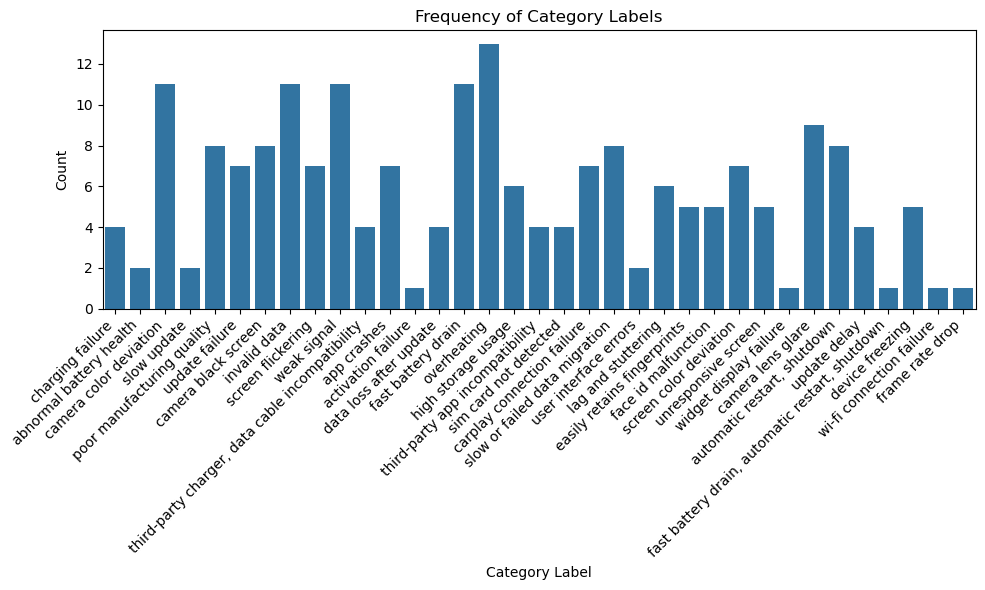

,summary
category,
abnormal battery health,2
activation failure,1
app crashes,7
"automatic restart, shutdown",8
camera black screen,8
camera color deviation,11
camera lens glare,9
carplay connection failure,7
charging failure,4


In [57]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=results[['category']])
plt.title('Frequency of Category Labels')
plt.xlabel('Category Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

statistic_label = results.pivot_table(index='category',aggfunc='count')
statistic_label[['summary']]

### 5.1 Define system prompt and user prompt template
- we add instruction to generate report in certain content agenda as:
```markdown
# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. This section should be concise, allowing readers to grasp the main points quickly.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.
```

- And add additional context of statistic data in json


In [63]:
user = """
You are a data analysis expert in the retail industry
Your task is to analyze the given data and write a data analysis report. Follow these instructions:

- instructions:
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative|
- the report should follow the content agenda as below:

# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. This section should be concise, allowing readers to grasp the main points quickly.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.


Here is the tabular data in json to analyze:
{tabular}

Here are the statistic data in json:
{statistic}

Please generate the report in markdown format:
"""

- Create a langchain chat template

In [64]:
prompt_advanced_1 = ChatPromptTemplate([
    ('user',user),
    ])
chain_advanced = prompt_advanced_1 | llm | StrOutputParser()

- convert the tabular data and statistic to json string and pass them to llm

In [65]:
response_advanced = ''
for chunk in chain_advanced.stream({"tabular":results.to_json(),
                          'statistic':statistic_label['summary'].to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response_advanced += chunk

# Executive Summary
This report analyzes user feedback on various smartphone models and related products. The data reveals several key issues, including:

- **Battery Health**: Users reported abnormal battery health in 2% of the cases.
- **App Crashes**: App crashes were a significant issue, with 7% of users experiencing this problem.
- **Camera Issues**: Camera-related problems, such as color deviation and black screens, affected 11% of users.
- **Signal Problems**: Users reported weak signals and SIM card detection issues in 11% of cases.
- **Overheating**: Overheating was a concern for 13% of users.
- **Data Migration**: Slow or failed data migration was a challenge for 8% of users.
- **User Interface**: User interface errors and screen flickering affected 2% and 7% of users, respectively.

# Data Presentation
The dataset used for this analysis includes 200 user feedback entries, covering various smartphone models and related products. The data was collected from social media platfo

### 5.2 Display the report in markdown

In [68]:
from IPython.display import Markdown, display,HTML
display(Markdown(response_advanced))

# Executive Summary
This report analyzes user feedback on various smartphone models and related products. The data reveals several key issues, including:

- **Battery Health**: Users reported abnormal battery health in 2% of the cases.
- **App Crashes**: App crashes were a significant issue, with 7% of users experiencing this problem.
- **Camera Issues**: Camera-related problems, such as color deviation and black screens, affected 11% of users.
- **Signal Problems**: Users reported weak signals and SIM card detection issues in 11% of cases.
- **Overheating**: Overheating was a concern for 13% of users.
- **Data Migration**: Slow or failed data migration was a challenge for 8% of users.
- **User Interface**: User interface errors and screen flickering affected 2% and 7% of users, respectively.

# Data Presentation
The dataset used for this analysis includes 200 user feedback entries, covering various smartphone models and related products. The data was collected from social media platforms and online forums.

# Findings
The analysis revealed several key findings:

- **Battery Health**: Users reported abnormal battery health in 2% of the cases.
- **App Crashes**: App crashes were a significant issue, with 7% of users experiencing this problem.
- **Camera Issues**: Camera-related problems, such as color deviation and black screens, affected 11% of users.
- **Signal Problems**: Users reported weak signals and SIM card detection issues in 11% of cases.
- **Overheating**: Overheating was a concern for 13% of users.
- **Data Migration**: Slow or failed data migration was a challenge for 8% of users.
- **User Interface**: User interface errors and screen flickering affected 2% and 7% of users, respectively.

# Discussion
The findings suggest that users are facing several issues with their smartphones and related products. Battery health, app crashes, camera issues, signal problems, overheating, data migration, and user interface are the most critical areas that need improvement.

# Conclusions
The analysis highlights the need for manufacturers to address these issues to improve user satisfaction and loyalty. By focusing on these areas, manufacturers can enhance the user experience and build a positive brand reputation.

# Recommendations
Based on the findings, here are some recommendations for manufacturers:

- **Battery Health**: Manufacturers should invest in improving battery health and providing clear instructions for users to maintain their battery health.
- **App Crashes**: Manufacturers should work closely with app developers to ensure app compatibility and stability.
- **Camera Issues**: Manufacturers should invest in improving camera quality and providing clear instructions for users to optimize camera settings.
- **Signal Problems**: Manufacturers should work closely with network providers to ensure signal stability and compatibility.
- **Overheating**: Manufacturers should invest in improving heat dissipation and providing clear instructions for users to avoid overheating.
- **Data Migration**: Manufacturers should invest in improving data migration processes and providing clear instructions for users to transfer data smoothly.
- **User Interface**: Manufacturers should invest in improving user interface design and providing clear instructions for users to navigate the interface effectively.